## Playing with PUDL
This notebook is meant to help get you up and running with the PUDL database, so you can play with it!

### Importing external code.
We need to import a bunch of outside code to do our work here.  Sometimes we import entire packages (like `numpy` and `pandas`) and sometimes we just pull in a couple of pieces we need from a particular part of a large package (like `declarative_base`)

In [1]:
import sys
import os.path
sys.path.append(os.path.abspath(os.path.join('..','..')))
from pudl import pudl, ferc1, eia923, settings, constants
from pudl import models, models_ferc1, models_eia923
import numpy as np
import pandas as pd
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from sqlalchemy.engine.url import URL
import matplotlib.pyplot as plt
import datetime as dt
%matplotlib inline
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter

### Connecting to the PUDL database:

In [2]:
pudl_engine  = pudl.connect_db()

# Pull generation_fuel data from PUDL EIA923 tables

### Generation_fuel_eia923 gives info on heat rates, fuel consumed, & electricity generated

In [3]:
gf = pd.read_sql('''SELECT plant_id, report_date, fuel_type, aer_fuel_type, aer_fuel_category, \
                            fuel_consumed_total, fuel_consumed_for_electricity, fuel_mmbtu_per_unit, \
                            fuel_consumed_total_mmbtu, fuel_consumed_for_electricity_mmbtu, \
                            net_generation_mwh \
                            FROM generation_fuel_eia923''', pudl_engine)

In [4]:
pi = pd.read_sql('''SELECT plant_id, plant_state, nameplate_capacity_mw FROM plants_eia923''', pudl_engine)

In [5]:
mwh_eia923 = pd.merge(gf, pi, on='plant_id')


In [6]:
mwh_eia923.head(1)

,plant_id,report_date,fuel_type,aer_fuel_type,aer_fuel_category,fuel_consumed_total,fuel_consumed_for_electricity,fuel_mmbtu_per_unit,fuel_consumed_total_mmbtu,fuel_consumed_for_electricity_mmbtu,net_generation_mwh,plant_state,nameplate_capacity_mw
0,2,2009-01-01,WAT,HYC,hydro,0.0,0.0,0.0,282335.0,282335.0,28927.787,AL,45.0


In [7]:
mwh_eia923["report_date"] = pd.to_datetime(mwh_eia923.report_date)

In [8]:
# Examining data at annual scale here, so only creating year field
mwh_eia923["year"] = mwh_eia923["report_date"].dt.year
mwh_eia923["month"] = mwh_eia923["report_date"].dt.month

In [9]:
mwh_eia923.year.values

array([2009, 2009, 2009, ..., 2016, 2016, 2016])

In [10]:
# Look at full data set to see how "date" column is formatted
mwh_eia923.head(1)

,plant_id,report_date,fuel_type,aer_fuel_type,aer_fuel_category,fuel_consumed_total,fuel_consumed_for_electricity,fuel_mmbtu_per_unit,fuel_consumed_total_mmbtu,fuel_consumed_for_electricity_mmbtu,net_generation_mwh,plant_state,nameplate_capacity_mw,year,month
0,2,2009-01-01,WAT,HYC,hydro,0.0,0.0,0.0,282335.0,282335.0,28927.787,AL,45.0,2009,1


### EIA923 Heat rate calculations

In [11]:
# Summarize data by year for each plant; this creates a new column that reports the annual sum in each row
mwh_eia923["fuel_consumed_total_mmbtu_sum"] = mwh_eia923.groupby(["plant_id", "year"])["fuel_consumed_total_mmbtu"].transform(sum)
mwh_eia923["net_generation_mwh_sum"] = mwh_eia923.groupby(["plant_id", "year"])["net_generation_mwh"].transform(sum)

In [12]:
# Use sum of fuel_consumed_total_mmbtu_sum and net_generation_mwh_sum to calculate annual heat rate 
# for each plant id
mwh_eia923['calculated_heat_rate_btu_per_kwh'] = \
((mwh_eia923['fuel_consumed_total_mmbtu_sum']*1000000)/(mwh_eia923['net_generation_mwh_sum']*1000))

In [13]:
# List of fuel categories we have to work with 
mwh_eia923.aer_fuel_category.unique()

array(['hydro', 'gas', 'coal', 'petroleum', 'petroleum coke', 'other',
       'nuclear', 'wind', 'solar', None], dtype=object)

In [14]:
# Subset of just coal data 
mwh_eia923_coal = mwh_eia923[(mwh_eia923.aer_fuel_category == 'coal')]

In [15]:
# Subset of just natural gas data
mwh_eia923_gas = mwh_eia923[(mwh_eia923.aer_fuel_category == 'gas')]

/home/alana/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:583: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/home/alana/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:584: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


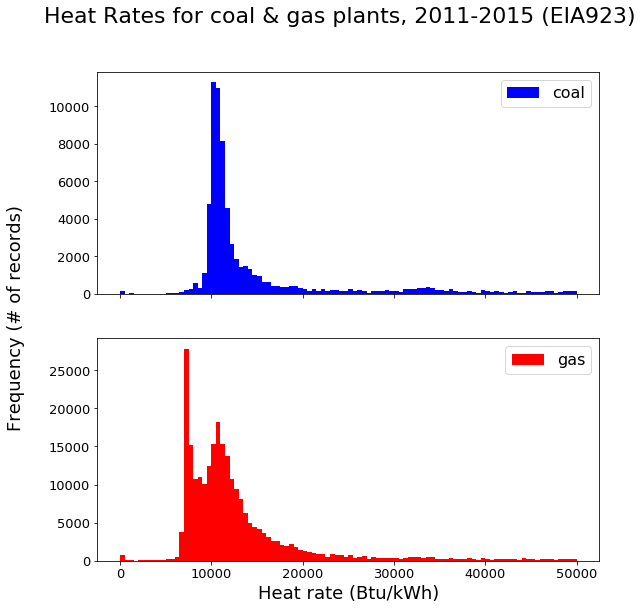

In [16]:
# Plot heat rate histogram for full data set by fuel type
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.hist(mwh_eia923_coal.calculated_heat_rate_btu_per_kwh, color= 'b', label='coal', range=(0,50000), bins=100)
ax1.legend(loc="upper right", fontsize=16)
ax1.yaxis.set_tick_params(labelsize=13)
ax2.hist(mwh_eia923_gas.calculated_heat_rate_btu_per_kwh, color= 'r', label='gas', range=(0,50000), bins=100)
ax2.legend(loc="upper right", fontsize=16)
plt.suptitle('Heat Rates for coal & gas plants, 2011-2015 (EIA923)', size=22)
ax2.set_xlabel('Heat rate (Btu/kWh)', size=18)
f.text(0.0, 0.5, 'Frequency (# of records)', ha='center', va='center', rotation='vertical', size=18)
f.set_size_inches(9,9)
plt.tick_params(axis='both', which='major', labelsize=13)
plt.show()

In [17]:
# # Calculate a monthly sum of fuel quantity & fuel content by fuel group and contract type
mwh_eia923["annual_net_generation_mwh"] = mwh_eia923.groupby(["year", "plant_id"])["net_generation_mwh"].transform(sum)
mwh_eia923['calculated_capacity_factor'] = mwh_eia923['annual_net_generation_mwh'] /(mwh_eia923['nameplate_capacity_mw']*8760)


/home/alana/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:583: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/home/alana/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:584: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


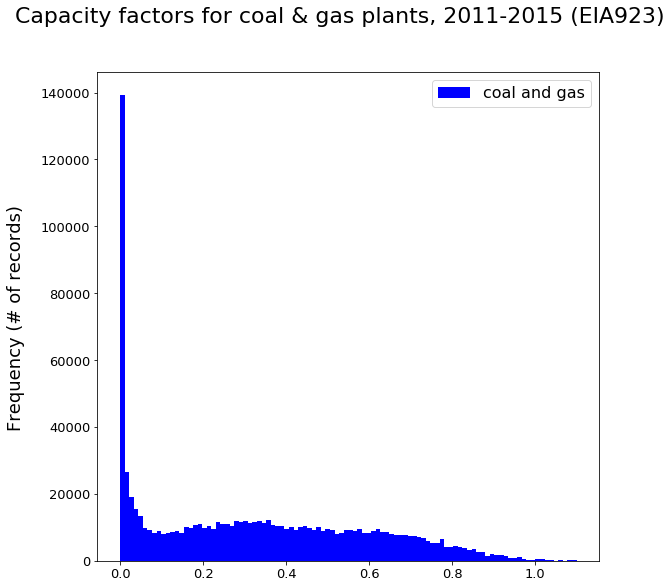

In [18]:
# Plot capacity factor histogram for full data set by fuel type
f, (ax1) = plt.subplots(1, 1, sharex=True)
ax1.hist(mwh_eia923.calculated_capacity_factor, color= 'b', label='coal and gas', range=(0,1.1), bins=100)
ax1.legend(loc="upper right", fontsize=16)
ax1.yaxis.set_tick_params(labelsize=13)
plt.suptitle('Capacity factors for coal & gas plants, 2011-2015 (EIA923)', size=22)
ax2.set_xlabel('Capacity factor ()', size=18)
f.text(0.0, 0.5, 'Frequency (# of records)', ha='center', va='center', rotation='vertical', size=18)
f.set_size_inches(9,9)
plt.tick_params(axis='both', which='major', labelsize=13)
plt.show()

# Pull fuel_receipts_costs data from PUDL EIA923 tables


### Fuel_receipts_costs_eia923 gives info on heat content, fuel cost, and fuel purchase types

In [19]:
fuel_cost_eia923 = pd.read_sql('''SELECT plant_id, report_date, \
                                energy_source, fuel_group, contract_type, contract_expiration_date, mine_id, \
                                fuel_quantity, average_heat_content, average_sulfur_content \
                                average_ash_content, average_mercury_content, fuel_cost, primary_transportation_mode\
                                FROM fuel_receipts_costs_eia923 ''', pudl_engine)

In [21]:
# Looking at data at monthly scale, so creating both year and month fields
fuel_cost_eia923["report_date"] = pd.to_datetime(fuel_cost_eia923.report_date)
fuel_cost_eia923["year"] = fuel_cost_eia923["report_date"].dt.year
fuel_cost_eia923["month"] = fuel_cost_eia923["report_date"].dt.month

In [22]:
# Convert fuel costs from cents to dollars
fuel_cost_eia923['fuel_cost'] = fuel_cost_eia923['fuel_cost']/100

In [23]:
# Calculate heat_content_total by multiplying average_heat_content and fuel_quantity
fuel_cost_eia923["heat_content_total"] = (fuel_cost_eia923.average_heat_content*fuel_cost_eia923.fuel_quantity)

# # Calculate a monthly sum of fuel quantity & fuel content by fuel group and contract type
fuel_cost_eia923["monthly_fuel_quantity"] = fuel_cost_eia923.groupby(["year", "month", "fuel_group", "contract_type"])["fuel_quantity"].transform(sum)
fuel_cost_eia923["monthly_heat_content"] = fuel_cost_eia923.groupby(["year", "month", "fuel_group", "contract_type"])["heat_content_total"].transform(sum)

In [24]:
# Create purchase cost field, which is fuel_quantity * fuel_cost
fuel_cost_eia923["purchase_cost"] = (fuel_cost_eia923.fuel_cost*fuel_cost_eia923.fuel_quantity)

In [26]:
# Create data frames by fuel_group for all data
coal = fuel_cost_eia923[(fuel_cost_eia923.fuel_group == 'Coal')]
gas = fuel_cost_eia923[(fuel_cost_eia923.fuel_group == 'Natural Gas')]
petroleum = fuel_cost_eia923[(fuel_cost_eia923.fuel_group == 'Petroleum')]
petcoke = fuel_cost_eia923[(fuel_cost_eia923.fuel_group == 'Petroleum_Coke')]

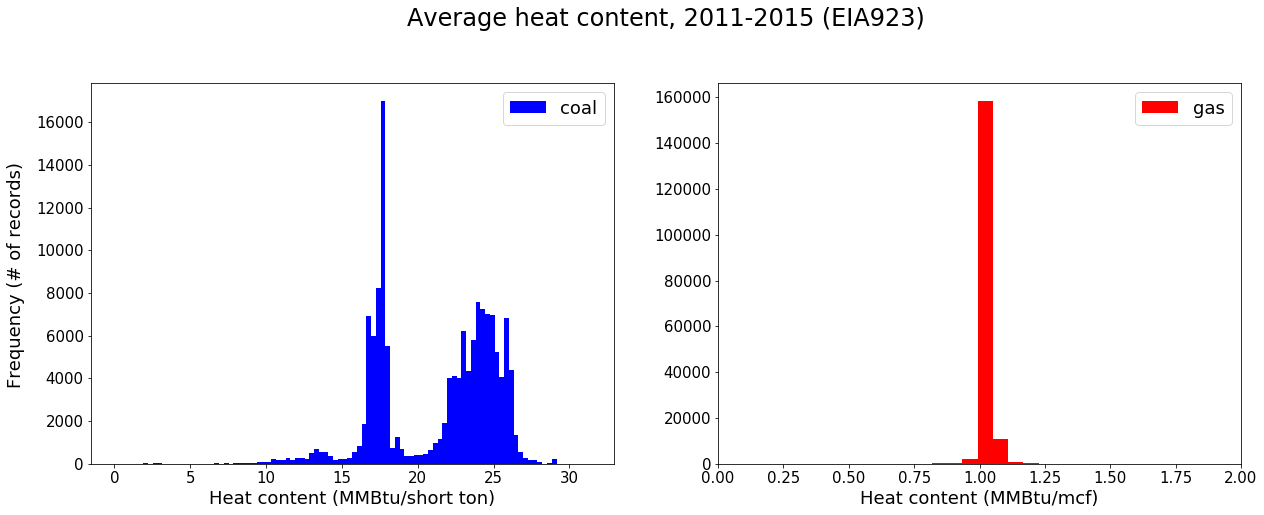

In [27]:
# Plot average heat content by fuel group
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.hist(coal.average_heat_content, color='b', label='coal', bins=100)
ax1.legend(loc="upper right", fontsize=18)
ax1.set_xlabel('Heat content (MMBtu/short ton)', size=18)
ax1.yaxis.set_tick_params(labelsize=15)
ax1.xaxis.set_tick_params(labelsize=15)
ax2.hist(gas.average_heat_content, color= 'r', label='gas', bins=100)
ax2.set_xlim(0,2)
ax2.legend(loc="upper right", fontsize=18)
ax2.set_xlabel('Heat content (MMBtu/mcf)', size=18)
plt.text(-0.1, 1.2,'Average heat content, 2011-2015 (EIA923)', ha='center', 
         va='top', transform=ax2.transAxes, fontsize=24)
plt.tick_params(axis='both', which='major', labelsize=15)
f.subplots_adjust(left=None, bottom=None, right=1.9, top=None, wspace=None, hspace=None)
f.set_size_inches(9,7)
f.text(.01, 0.5, 'Frequency (# of records)', ha='center', va='center', rotation='vertical', fontsize=18)
plt.show()

### Fuel cost analysis

In [28]:
# Many records have NA fuel cost value, but have fuel quantity, heat content, etc. data
# Thus we only need to remove the NA values for the cost calculations
# Remove any negative or NA fuel cost values and call this 'positive_fuel'
positive_fuel = fuel_cost_eia923[fuel_cost_eia923['fuel_cost'] > 0]
# TODO: check to see how many records are being dropped

3.537

In [30]:
# Subset fuel_cost dataframes by fuel type
fuel_cost_coal = positive_fuel[(positive_fuel.fuel_group == 'Coal')]
fuel_cost_gas = positive_fuel[(positive_fuel.fuel_group == 'Natural Gas')]
fuel_cost_coal.shape

(101742, 19)

In [31]:
# Check maximum fuel cost for natural gas (in $)
fuel_cost_gas.fuel_cost.max()

235381.13

In [33]:
# Natural gas fuel costs have high values that are unrealistic 
# Separate the values that are over $50/MMBtu
fuel_cost_gas_high = fuel_cost_gas[fuel_cost_gas['fuel_cost'] >50]
fuel_cost_gas = fuel_cost_gas[fuel_cost_gas['fuel_cost'] <=50]

49.725000000000001

In [34]:
# How many natural gas records exceed $50/MMBtu?
fuel_cost_gas_high.shape

(691, 19)

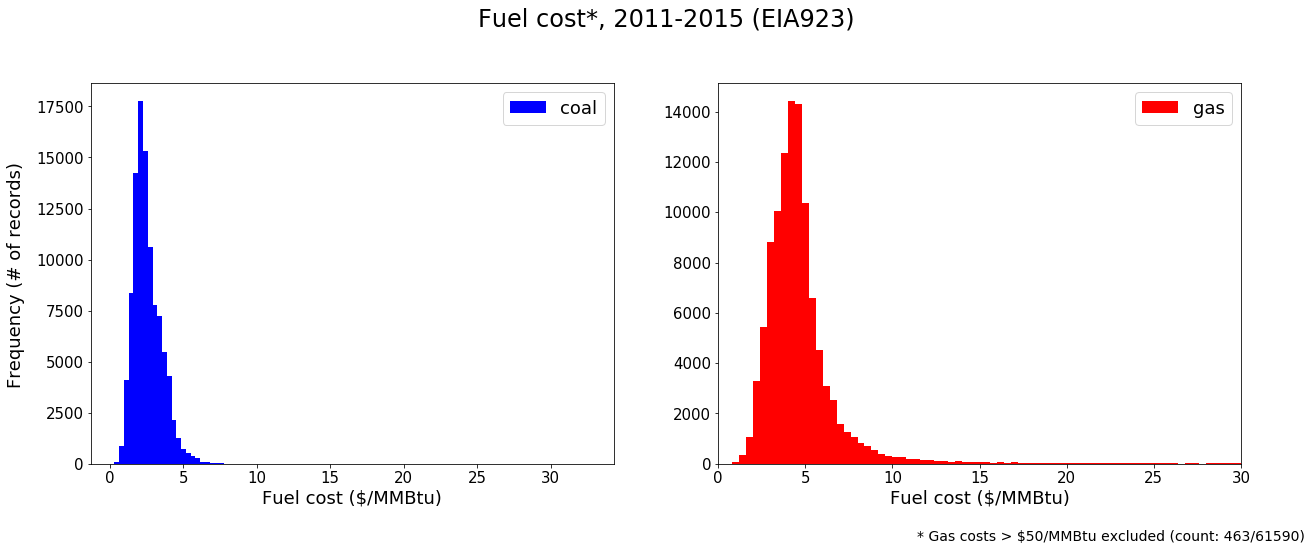

In [35]:
# Plot fuel cost per MMBtu by fuel group

f, (ax1, ax2) = plt.subplots(1, 2)
ax1.hist(fuel_cost_coal.fuel_cost, color='b', label='coal', bins=100)
ax1.legend(loc="upper right", fontsize=18)
ax1.set_xlabel('Fuel cost ($/MMBtu)', size=18)
ax1.yaxis.set_tick_params(labelsize=15)
ax1.xaxis.set_tick_params(labelsize=15)
ax2.hist(fuel_cost_gas.fuel_cost, color= 'r', label='gas', range=(0,40), bins=100)
ax2.set_xlim(0,30)
ax2.legend(loc="upper right", fontsize=18)
ax2.set_xlabel('Fuel cost ($/MMBtu)', size=18)
plt.text(-0.1, 1.2,'Fuel cost*, 2011-2015 (EIA923)', ha='center', 
         va='top', transform=ax2.transAxes, fontsize=24)
plt.tick_params(axis='both', which='major', labelsize=15)
f.subplots_adjust(left=None, bottom=None, right=1.9, top=None, wspace=None, hspace=None)
f.set_size_inches(9,7)
f.text(.01, 0.5, 'Frequency (# of records)', ha='center', va='center', rotation='vertical', fontsize=18)

f.text(1.7, -0.02, '* Gas costs > $50/MMBtu excluded (count: 691/61590)', ha='center', va='center', fontsize=14)
plt.show()

### Look at fuel data by contract type
### Calculating monthly averages and sums means individual records are lost and other fields should not be used (TODO: remove the non-monthly data columns when monthly values are calculated)

In [36]:
# Monthly averages use variable divided by total fuel quantity for weighted monthly averages by fuel group & contract type 
# Other monthly fields (monthly_fuel_quantity & monthly_purchase_cost) are summed by fuel group & contract type
# fuel_cost_eia923 dataframe is used for non-cost-related data
# positve_fuel dataframe is used for cost-related data
fuel_cost_eia923["monthly_average_heat_content"] = ((fuel_cost_eia923.groupby(["year", "month", "fuel_group", "contract_type"])["heat_content_total"].transform(sum))/(fuel_cost_eia923.groupby(["year", "month", "fuel_group", "contract_type"])["fuel_quantity"].transform(sum)))
fuel_cost_eia923["monthly_fuel_quantity"] = ((fuel_cost_eia923.groupby(["year", "month", "fuel_group", "contract_type"])["fuel_quantity"].transform(sum)))
fuel_cost_eia923["monthly_purchase_cost"] = ((fuel_cost_eia923.groupby(["year", "month", "fuel_group", "contract_type"])["purchase_cost"].transform(sum)))
positive_fuel["monthly_average_fuel_cost"] = ((positive_fuel.groupby(["year", "month", "fuel_group", "contract_type"])["purchase_cost"].transform(sum))/(positive_fuel.groupby(["year", "month", "fuel_group", "contract_type"])["fuel_quantity"].transform(sum)))
positive_fuel["monthly_fuel_quantity"] = ((positive_fuel.groupby(["year", "month", "fuel_group", "contract_type"])["fuel_quantity"].transform(sum)))
positive_fuel["monthly_purchase_cost"] = ((positive_fuel.groupby(["year", "month", "fuel_group", "contract_type"])["purchase_cost"].transform(sum)))

# Drop duplicates of monthly sums/averages, so we lose indvidual purchase records but retain monthly data by fuel group & contract type
fuel_cost_eia923 = fuel_cost_eia923.drop_duplicates(subset=['report_date', 'fuel_group', 'contract_type'])
positive_fuel = positive_fuel.drop_duplicates(subset=['report_date', 'fuel_group', 'contract_type'])

/home/alana/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/alana/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/alana/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/i

In [39]:
# Monthly records for coal purchased by contract or new contract
contract_buy_coal = fuel_cost_eia923[((fuel_cost_eia923.contract_type == 'C')|(fuel_cost_eia923.contract_type == 'NC')) & (fuel_cost_eia923.fuel_group == 'Coal')]
contract_buy_coal.head(2)

,plant_id,report_date,energy_source,fuel_group,contract_type,contract_expiration_date,mine_id,fuel_quantity,average_heat_content,average_ash_content,...,fuel_cost,primary_transportation_mode,year,month,heat_content_total,monthly_fuel_quantity,monthly_heat_content,purchase_cost,monthly_average_heat_content,monthly_purchase_cost
0,3,2009-01-01,BIT,Coal,C,2009-12-01,None,120393.0,24.00,1.0,...,6.311,RV,2009,1,2889432.00,77258582.0,1.506515e+09,759800.223,19.499641,1.096186e+08
45,47,2009-01-01,BIT,Coal,NC,None,None,26636.0,24.87,0.8,...,3.897,RV,2009,1,662437.32,1814457.0,3.845251e+07,103800.492,21.192295,5.238491e+06


In [40]:
#merge contracts and new contracts into the same category for fields of interest
contract_buy_coal["monthly_fuel_quantity"] = contract_buy_coal.groupby(["report_date"])["monthly_fuel_quantity"].transform(sum)
contract_buy_coal["monthly_heat_content"] = contract_buy_coal.groupby(["report_date"])["monthly_heat_content"].transform(sum)
contract_buy_coal["monthly_average_heat_content"] = ((contract_buy_coal.groupby(["report_date"])["monthly_heat_content"].transform(sum))/(contract_buy_coal.groupby(["report_date"])["fuel_quantity"].transform(sum)))
contract_buy_coal = contract_buy_coal.drop_duplicates(subset=['report_date'])
contract_buy_coal.shape

/home/alana/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/home/alana/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/alana/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

(95, 21)

In [71]:
# Monthly records of costs for coal purchased by contract or new contract
contract_buy_coal_costs = positive_fuel[((positive_fuel.contract_type == 'C')|(positive_fuel.contract_type == 'NC')) & (positive_fuel.fuel_group == 'Coal')]

In [43]:
#merge contracts and new contracts into the same category
contract_buy_coal_costs["monthly_heat_content"] = contract_buy_coal_costs.groupby(["report_date"])["monthly_heat_content"].transform(sum)
contract_buy_coal_costs["monthly_average_fuel_cost"] = ((contract_buy_coal_costs.groupby(["report_date"])["monthly_purchase_cost"].transform(sum))/(contract_buy_coal_costs.groupby(["report_date"])["monthly_fuel_quantity"].transform(sum)))
contract_buy_coal_costs["monthly_fuel_quantity"] = contract_buy_coal_costs.groupby(["report_date"])["monthly_fuel_quantity"].transform(sum)
contract_buy_coal_costs = contract_buy_coal_costs.drop_duplicates(subset=['report_date'])
contract_buy_coal_costs.shape

/home/alana/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/home/alana/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/alana/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

(95, 21)

In [72]:
# Monthly records for natural gas purchased by contract or new contract
contract_buy_gas = fuel_cost_eia923[((fuel_cost_eia923.contract_type == 'C')|(fuel_cost_eia923.contract_type == 'NC')) & (fuel_cost_eia923.fuel_group == 'Natural Gas')]

In [46]:
#merge contracts and new contracts into the same category
contract_buy_gas["monthly_heat_content"] = contract_buy_gas.groupby(["report_date"])["monthly_heat_content"].transform(sum)
contract_buy_gas["monthly_fuel_quantity"] = contract_buy_gas.groupby(["report_date"])["monthly_fuel_quantity"].transform(sum)
contract_buy_gas["monthly_average_heat_content"] = contract_buy_gas.groupby(["report_date"])["monthly_average_heat_content"].transform(sum)
contract_buy_gas = contract_buy_gas.drop_duplicates(subset=['report_date'])

/home/alana/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/home/alana/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/alana/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

In [73]:
# Monthly records of costs for natural gas purchased by contract or new contract
contract_buy_gas_costs = positive_fuel[((positive_fuel.contract_type == 'C')|(positive_fuel.contract_type == 'NC')) & (positive_fuel.fuel_group == 'Natural Gas')]

In [49]:
#merge contracts and new contracts into the same category
contract_buy_gas_costs["monthly_heat_content"] = contract_buy_gas_costs.groupby(["report_date"])["monthly_heat_content"].transform(sum)
contract_buy_gas_costs["monthly_fuel_quantity"] = contract_buy_gas_costs.groupby(["report_date"])["monthly_fuel_quantity"].transform(sum)
contract_buy_gas_costs["monthly_average_fuel_cost"] = contract_buy_gas_costs.groupby(["report_date"])["monthly_average_fuel_cost"].transform(sum)
contract_buy_gas_costs = contract_buy_gas_costs.drop_duplicates(subset=['report_date'])
contract_buy_gas_costs.shape

/home/alana/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/home/alana/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/alana/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

(95, 21)

In [50]:
# Monthly records for spot purchases of coal
spot_buy_coal = fuel_cost_eia923[(fuel_cost_eia923.contract_type == 'S') & (fuel_cost_eia923.fuel_group == 'Coal')]
spot_buy_coal.shape

(95, 21)

In [74]:
# Monthly records of costs for spot purchases of coal
spot_buy_coal_costs = positive_fuel[(positive_fuel.contract_type == 'S') & (positive_fuel.fuel_group == 'Coal')]

In [52]:
# Monthly records for spot purchases of natural gas
spot_buy_gas = fuel_cost_eia923[(fuel_cost_eia923.contract_type == 'S') & (fuel_cost_eia923.fuel_group == 'Natural Gas')]

In [53]:
# Monthly records of costs for spot purchases of natural gas
spot_buy_gas_costs = positive_fuel[(positive_fuel.contract_type == 'S') & (positive_fuel.fuel_group == 'Natural Gas')]

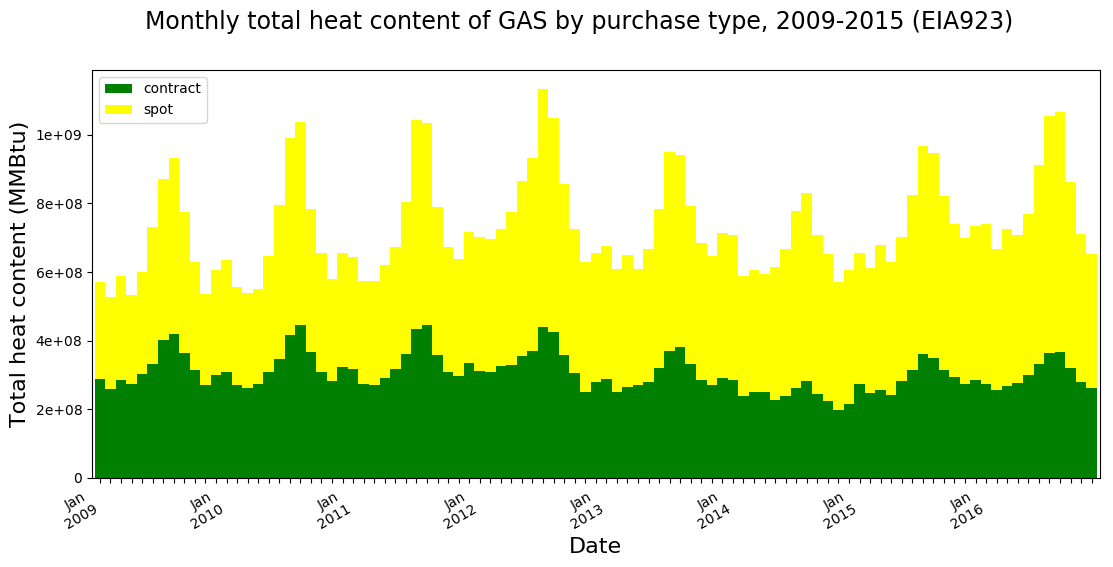

In [55]:
# Plot monthly total heat content for natural gas by contract type
fig = plt.figure(figsize=(13,6), dpi=100)
ax = plt.subplot(111)
p1 = contract_buy_gas.monthly_heat_content.plot(kind='bar', x=contract_buy_gas.report_date, width=1.0, stacked=True, color='green', label='contract')
p2 = spot_buy_gas.monthly_heat_content.plot(kind='bar', x=spot_buy_gas.report_date, width=1.0, stacked=True, bottom=contract_buy_gas.monthly_heat_content, color='yellow', label='spot')

# Make most of the ticklabels empty so the labels don't get too crowded
ticklabels = ['']*len(contract_buy_gas.index)
# Every 4th ticklable shows the month and/or day
# ticklabels[::4] = [item.strftime('%b %d') for item in contract_buy_coal.report_date[::12]] #shows month and day
# ticklabels[::4] = [item.strftime('%b') for item in contract_buy_coal.report_date[::12]] #shows month

# Every 12th ticklabel includes the year
ticklabels[::12] = [item.strftime('%b \n%Y') for item in contract_buy_gas.report_date[::12]] #shows month, year
ax.xaxis.set_major_formatter(ticker.FixedFormatter(ticklabels))
ax.set_ylabel('Total heat content (MMBtu)', size=16)
ax.set_xlabel('Date', size=16)
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%g'))
plt.gcf().autofmt_xdate()
plt.legend()
plt.suptitle('Monthly total heat content of GAS by purchase type, 2009-2015 (EIA923)', size=17)
plt.show()

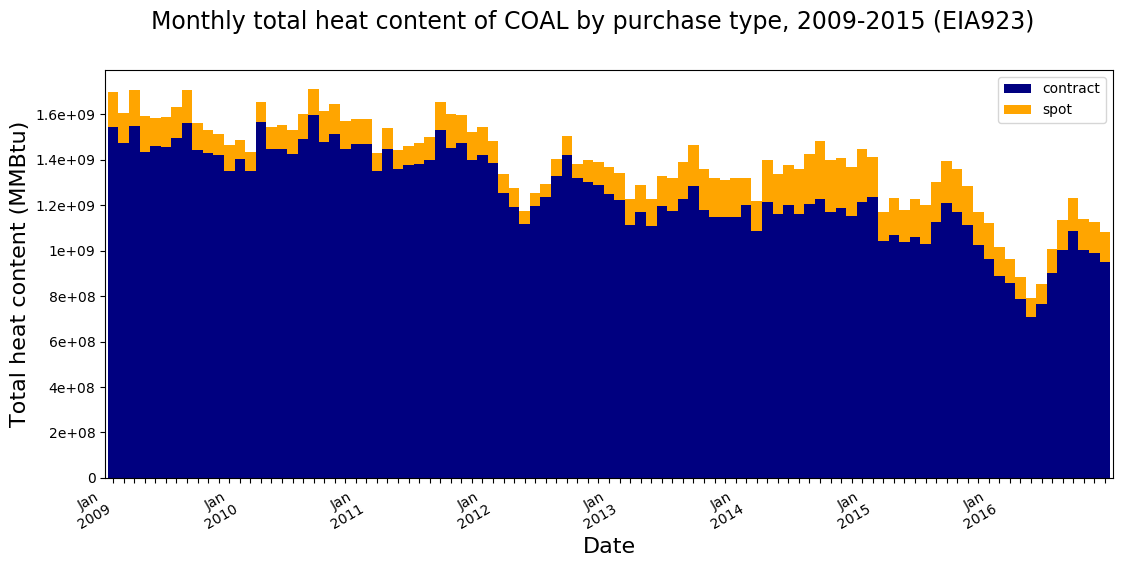

In [56]:
# Plot monthly total heat content for coal by contract type

fig = plt.figure(figsize=(13,6), dpi=100)
ax = plt.subplot(111)
p1 = contract_buy_coal.monthly_heat_content.plot(kind='bar', x=contract_buy_coal.report_date, width=1.0, stacked=True, colormap='jet', label='contract')
p2 = spot_buy_coal.monthly_heat_content.plot(kind='bar', x=contract_buy_coal.report_date,  width=1.0,stacked=True, bottom=contract_buy_coal.monthly_heat_content, color='orange', label='spot')
contract_buy_coal.heat_content_total.plot

# Make most of the ticklabels empty so the labels don't get too crowded
ticklabels = ['']*len(contract_buy_coal.index)

# Every 12th ticklabel includes the year
ticklabels[::12] = [item.strftime('%b \n%Y') for item in contract_buy_coal.report_date[::12]] #shows month, year
ax.xaxis.set_major_formatter(ticker.FixedFormatter(ticklabels))
ax.set_ylabel('Total heat content (MMBtu)', size=16)
ax.set_xlabel('Date', size=16)
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%g'))
plt.gcf().autofmt_xdate()
plt.legend()
plt.suptitle('Monthly total heat content of COAL by purchase type, 2009-2015 (EIA923)', size=17)
plt.show()

In [57]:
# To calculate proportional purchases, create two new data frames - one each for contract and spot purchases
dfc = pd.concat([contract_buy_coal['monthly_heat_content'], contract_buy_coal['report_date']], axis=1, keys=['contract', 'date'])
dfs = pd.concat([spot_buy_coal['monthly_heat_content'], spot_buy_coal['report_date']], axis=1, keys=['spot', 'date'])

In [59]:
# Create merged dataframe of contract and spot purchase total heat contents
sum = pd.merge(dfc, dfs, on='date')

In [61]:
# Add contract and spot heat contents together
heat_sum = sum.contract+sum.spot

In [62]:
# Calculate percentages
contract_heat_percent = (sum.contract/heat_sum)*100
spot_heat_percent = (sum.spot/heat_sum)*100

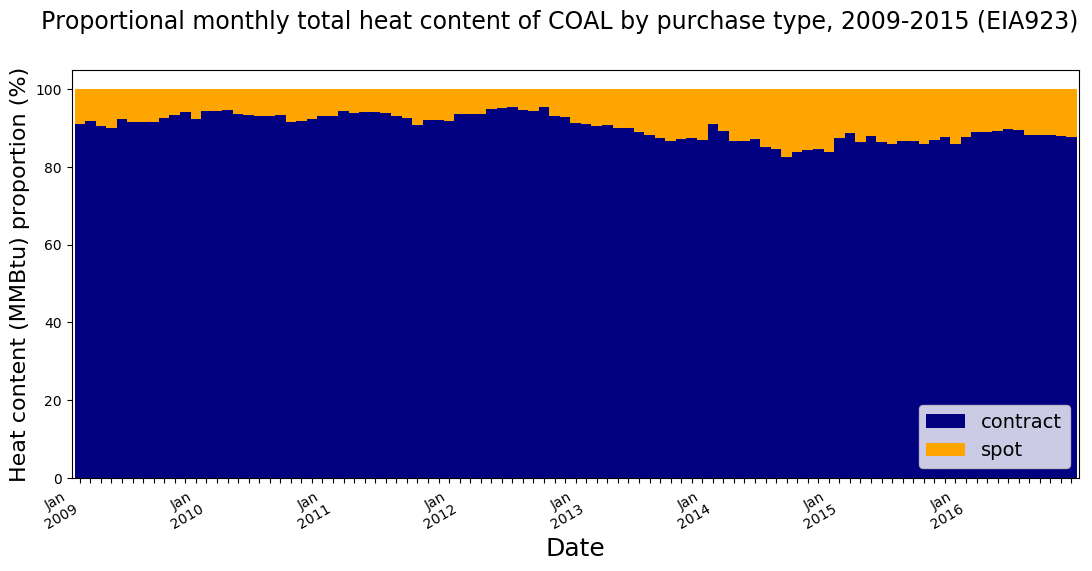

In [63]:
# Plot proportional heat content of coal purchases by contract type
fig = plt.figure(figsize=(13,6), dpi=100)
ax = plt.subplot(111)
p1 = contract_heat_percent.plot(kind='bar', x=contract_buy_coal.report_date, width=1.0, stacked=True, colormap='jet', label='contract')
p2 = spot_heat_percent.plot(kind='bar', x=spot_buy_coal.report_date,  width=1.0,stacked=True, bottom=contract_heat_percent, color='orange', label='spot')

# Make most of the ticklabels empty so the labels don't get too crowded
ticklabels = ['']*len(contract_buy_coal.index)

# Every 12th ticklabel includes the year
ticklabels[::12] = [item.strftime('%b \n%Y') for item in contract_buy_coal.report_date[::12]] #shows month, year
ax.xaxis.set_major_formatter(ticker.FixedFormatter(ticklabels))
ax.set_ylabel('Heat content (MMBtu) proportion (%)', size=16)
ax.set_xlabel('Date', size=18)
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%g'))
plt.gcf().autofmt_xdate()
plt.legend(bbox_to_anchor=(1, 0), loc='lower right', ncol=1, fontsize=14)
plt.suptitle('Proportional monthly total heat content of COAL by purchase type, 2009-2015 (EIA923)', size=17)
plt.show()

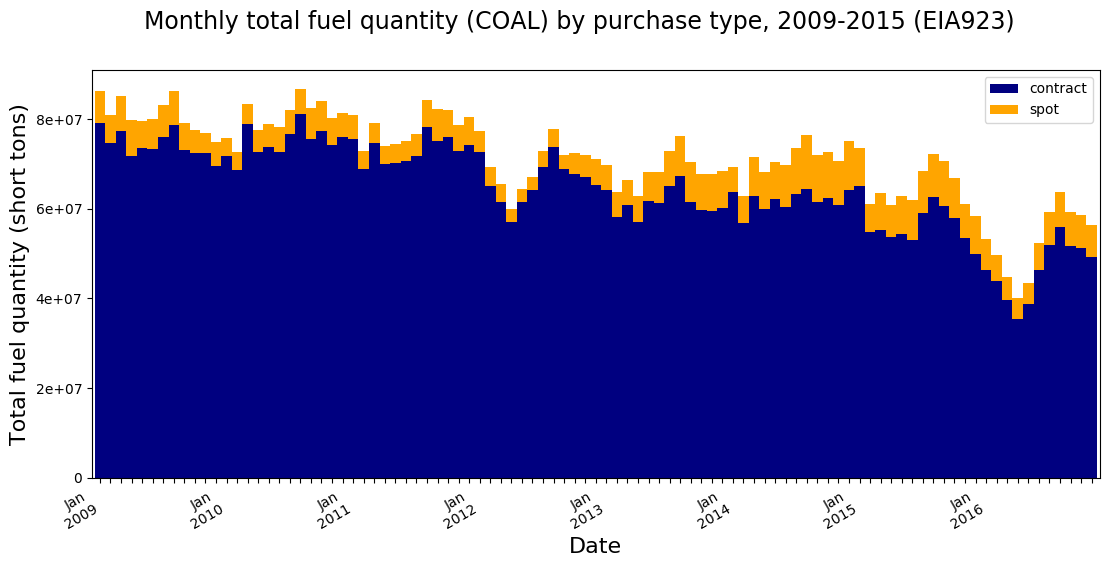

In [64]:
# Plot total fuel quantity of coal purchases by contract type
fig = plt.figure(figsize=(13,6), dpi=100)
ax = plt.subplot(111)
p1 = contract_buy_coal.monthly_fuel_quantity.plot(kind='bar', width=1.0, x=contract_buy_coal.report_date, stacked=True, colormap='jet', label='contract')
p2 = spot_buy_coal.monthly_fuel_quantity.plot(kind='bar', width=1.0, x=contract_buy_coal.report_date, stacked=True, bottom=contract_buy_coal.monthly_fuel_quantity, color='orange', label='spot')

# Make most of the ticklabels empty so the labels don't get too crowded
ticklabels = ['']*len(contract_buy_coal.index)

# Every 12th ticklabel includes the year
ticklabels[::12] = [item.strftime('%b \n%Y') for item in contract_buy_coal.report_date[::12]] #shows month, year
ax.xaxis.set_major_formatter(ticker.FixedFormatter(ticklabels))
ax.set_ylabel('Total fuel quantity (short tons)', size=16)
ax.set_xlabel('Date', size=16)
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%g'))
plt.gcf().autofmt_xdate()
plt.legend()
plt.suptitle('Monthly total fuel quantity (COAL) by purchase type, 2009-2015 (EIA923)', size=17)
plt.show()

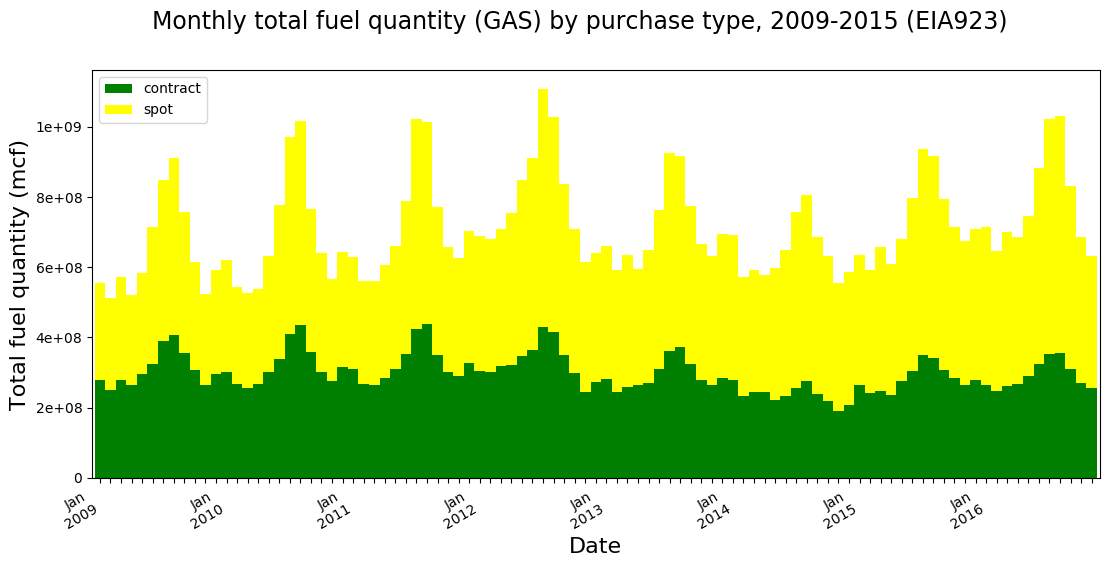

In [65]:
# Plot total fuel quantity of natural gas purchases by contract type
fig = plt.figure(figsize=(13,6), dpi=100)
ax = plt.subplot(111)
p1 = contract_buy_gas.monthly_fuel_quantity.plot(kind='bar',  width=1.0, x=contract_buy_gas.report_date, stacked=True, color='green', label='contract')
p2 = spot_buy_gas.monthly_fuel_quantity.plot(kind='bar',  width=1.0, x=contract_buy_gas.report_date, stacked=True, bottom=contract_buy_gas.monthly_fuel_quantity, color='yellow', label='spot')

# Make most of the ticklabels empty so the labels don't get too crowded
ticklabels = ['']*len(contract_buy_coal.index)

# Every 12th ticklabel includes the year
ticklabels[::12] = [item.strftime('%b \n%Y') for item in contract_buy_coal.report_date[::12]] #shows month, year
ax.xaxis.set_major_formatter(ticker.FixedFormatter(ticklabels))
ax.set_ylabel('Total fuel quantity (mcf)', size=16)
ax.set_xlabel('Date', size=16)
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%g'))
plt.gcf().autofmt_xdate()
plt.legend()
plt.suptitle('Monthly total fuel quantity (GAS) by purchase type, 2009-2015 (EIA923)', size=17)
plt.show()

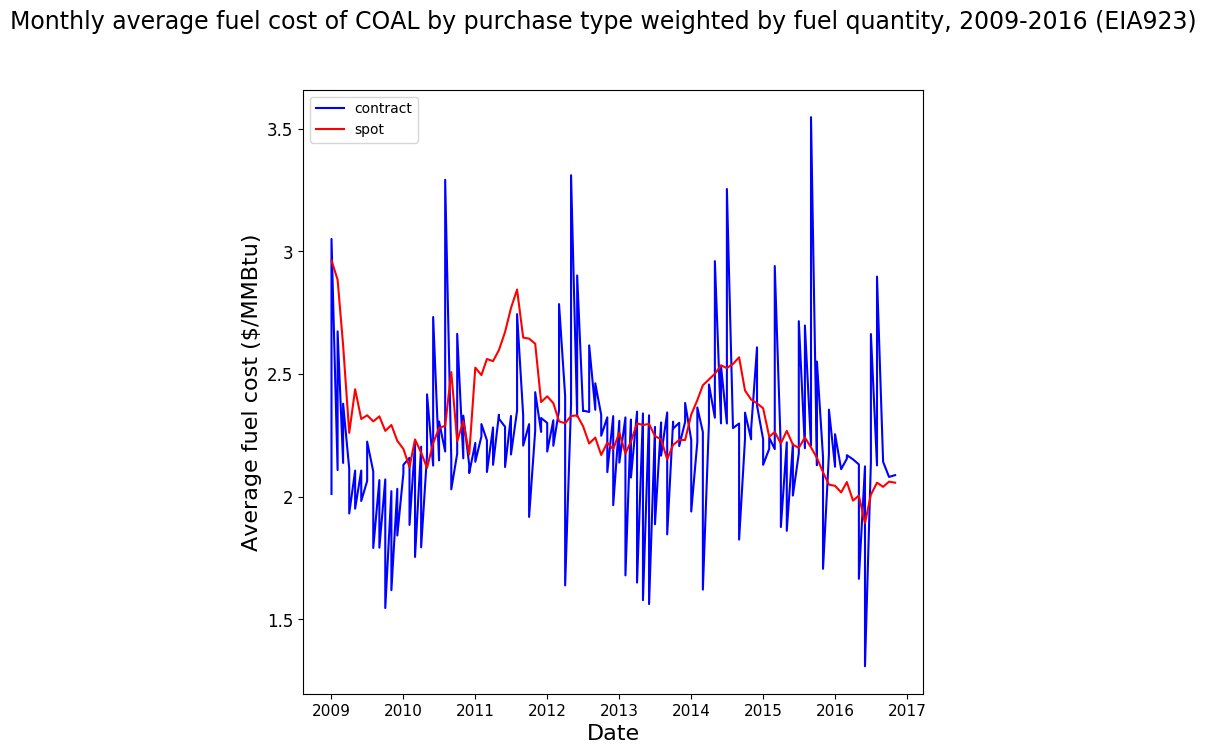

In [76]:
# Plot monthly fuel cost per MMBtu for coal by contract type

fig = plt.figure(figsize=(8, 8), dpi=100)
plt.plot_date(x=contract_buy_coal_costs.report_date, y=contract_buy_coal_costs.monthly_average_fuel_cost, linestyle='-', markersize = 0, color='b', label="contract")
plt.ylabel('Average fuel cost ($/MMBtu)', size=16)
plt.xlabel('Date', size=16)
plt.plot_date(x=spot_buy_coal_costs.report_date, y=spot_buy_coal_costs.monthly_average_fuel_cost, linestyle='-', marker='o', markersize=0, color='r', label="spot")
plt.legend()
from matplotlib.ticker import FormatStrFormatter
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%g'))
plt.xticks(size=11)
plt.yticks(size=12)
plt.suptitle('Monthly average fuel cost of COAL by purchase type weighted by fuel quantity, 2009-2016 (EIA923)', size=17)
plt.show()

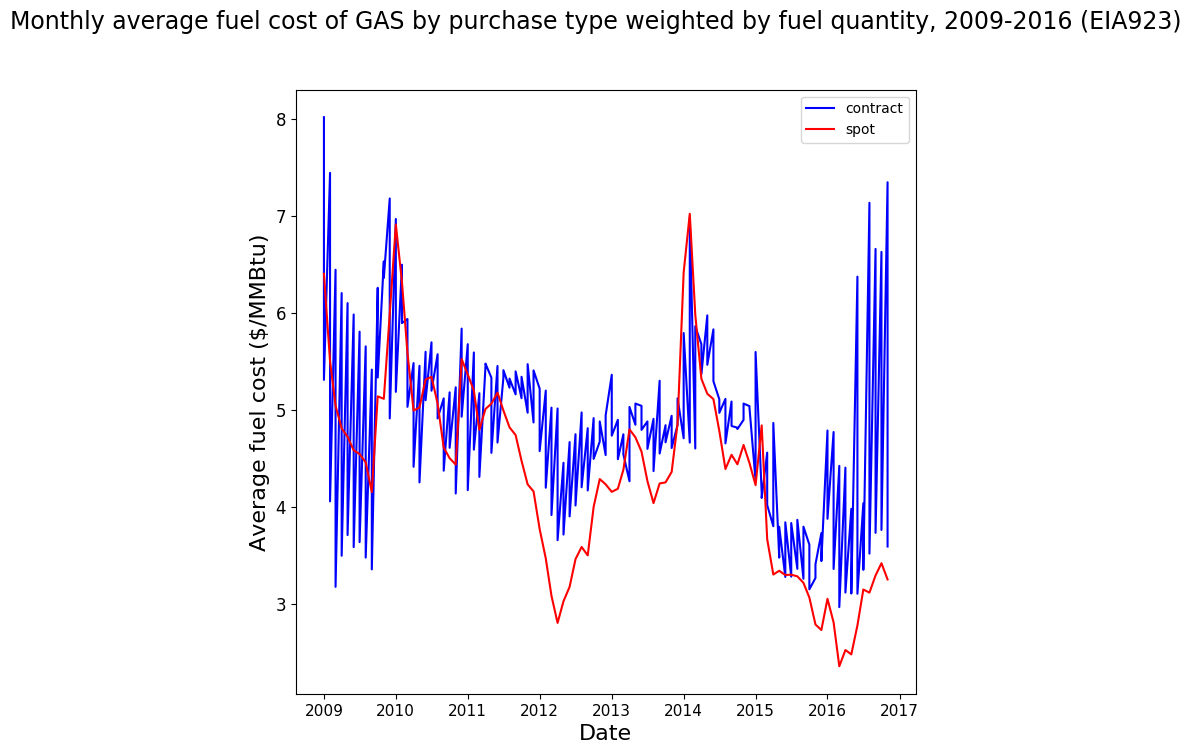

In [75]:
# Plot monthly fuel cost per MMBtu for gas by contract type

fig = plt.figure(figsize=(8, 8), dpi=100)
plt.plot_date(x=contract_buy_gas_costs.report_date, y=contract_buy_gas_costs.monthly_average_fuel_cost, linestyle='-', markersize = 0, color='b', label="contract")
plt.ylabel('Average fuel cost ($/MMBtu)', size=16)
plt.xlabel('Date', size=16)
plt.plot_date(x=spot_buy_gas_costs.report_date, y=spot_buy_gas_costs.monthly_average_fuel_cost, linestyle='-', marker='o', markersize=0, color='r', label="spot")
plt.legend()
from matplotlib.ticker import FormatStrFormatter
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%g'))
plt.xticks(size=11)
plt.yticks(size=12)
plt.suptitle('Monthly average fuel cost of GAS by purchase type weighted by fuel quantity, 2009-2016 (EIA923)', size=17)
plt.show()

